In [17]:
import torch
from pathlib import Path
import numpy as np
import scipy
from skimage import io
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
root_dir = Path.cwd().parent
data_dir = root_dir / 'data'
model_dir = root_dir / 'models'

root_dir
data_dir

PosixPath('/home/dkenez/Projects/PFAS---final-project/data')

In [7]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_dir / 'best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /home/dkenez/.cache/torch/hub/master.zip


requirements: /home/dkenez/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5 🚀 2023-5-1 Python-3.11.2 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5938MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [19]:
model.eval();

In [33]:
img_left_path = data_dir / "raw/final_project_2023_rect/seq_03/image_02/data/0000000000.png"  # or file, Path, PIL, OpenCV, numpy, list
img_right_path = data_dir / "raw/final_project_2023_rect/seq_03/image_03/data/0000000000.png"  # or file, Path, PIL, OpenCV, numpy, list

img_left = io.imread(img_left_path)
img_right = io.imread(img_right_path)


# Inference
results = model([img_left, img_right])

# Results
r = results.pandas().xywh

results_left_df = r[0]
results_right_df = r[1]

In [34]:
results_left_df.head()

,xcenter,ycenter,width,height,confidence,class,name
0,149.327255,280.016846,297.538971,173.097534,0.979079,0,Car
1,465.502411,182.963577,36.999084,25.168152,0.933816,0,Car
2,964.320557,218.467133,55.102417,146.168747,0.922818,1,Pedestrian
3,584.129395,231.440948,64.872192,172.853958,0.917541,1,Pedestrian
4,130.984802,227.547852,48.633926,116.422775,0.855283,1,Pedestrian


In [22]:
results_right_df.head()

,xmin,ymin,xmax,ymax,confidence,class,name
0,0.435599,189.113602,230.963516,367.301544,0.966724,0,Car
1,436.859192,170.783371,475.690277,195.233459,0.937884,0,Car
2,63.094082,169.932297,129.770386,297.414856,0.905551,1,Pedestrian
3,891.238708,142.718872,946.607849,292.072510,0.840327,1,Pedestrian
4,1058.777222,141.467896,1214.555054,193.976730,0.424304,0,Car


In [23]:
def match_objects(
    results_left_df: pd.DataFrame,
    results_right_df: pd.DataFrame,
    img_left_path: Path,
    img_right_path: Path,
) -> pd.DataFrame:
    """Match objects from left and right images.

    Args:
        results_left_df (pd.DataFrame): Results from left image.
        results_right_df (pd.DataFrame): Results from right image.
        calib_file (str): Path to calibration file.

    Returns:
        pd.DataFrame: Matched objects.
    """

    # read images and convert to gray
    img_left = io.imread(img_left_path)
    img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)
    img_right = io.imread(img_right_path)
    img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    
    nb_matches = 20
    sift = cv2.SIFT_create()
    bf = cv2.BFMatcher()
    im_height = img_left.shape[0]
    match_matrix = np.zeros((len(results_left_df.index), len(results_right_df.index)))
    for i1, bbox1 in results_left_df.iterrows():
        for i2, bbox2 in results_right_df.iterrows():
            cy1 = bbox1["ymin"] + bbox1["ymax"] / 2
            cy2 = bbox2["ymin"] + bbox2["ymax"] / 2
            if abs(cy1 - cy2) / im_height <= 0.1 and bbox1[5] == bbox2[5]:
                bbox1_im = img_left_gray[
                    int(bbox1["ymin"]) : int(bbox1["ymax"]),
                    int(bbox1["xmin"]) : int(bbox1["xmax"]),
                ]
                bbox2_im = img_right_gray[
                    int(bbox2["ymin"]) : int(bbox2["ymax"]),
                    int(bbox2["xmin"]) : int(bbox2["xmax"]),
                ]
                kp1, des1 = sift.detectAndCompute(bbox1_im, None)
                kp2, des2 = sift.detectAndCompute(bbox2_im, None)
                matches = bf.match(des1, des2)
                matches = sorted(matches, key=lambda x: x.distance)[:nb_matches]
                for m in matches:
                    match_matrix[i1, i2] += m.distance
            else:
                match_matrix[i1, i2] = np.inf

    row_ind, col_ind = scipy.optimize.linear_sum_assignment(match_matrix)

    return row_ind, col_ind

In [24]:
row_ind, col_ind = match_objects(
    r[0],
    r[1],
    img_left_path,
    img_right_path,
)

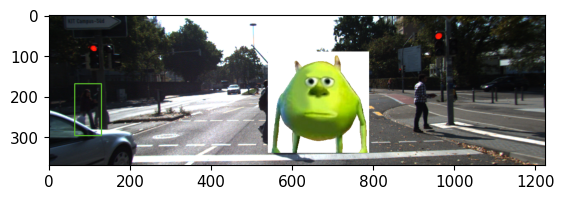

In [28]:
results_right_df

img_right = io.imread(img_right_path)


random_color = tuple(int(color) for color in np.random.choice(range(255),size=3))

box2 = results_right_df.iloc[2]
x_min = int(box2["xmin"])
y_min = int(box2["ymin"])
x_max = int(box2["xmax"])
y_max = int(box2["ymax"])
cv2.rectangle(img_right, (x_min, y_min), (x_max, y_max), random_color, 2)
plt.imshow(img_right)
plt.show()

In [29]:
print(col_ind)

[0 1 3 5 6 4]


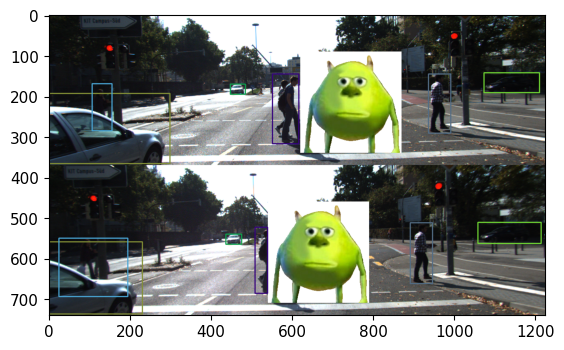

In [30]:
img_left = io.imread(img_left_path)
img_right = io.imread(img_right_path)

for i1,i2 in zip(row_ind, col_ind):
    # draw on left image
    random_color = tuple(int(color) for color in np.random.choice(range(255),size=3))
    box1 = results_left_df.iloc[i1]
    x_min = int(box1["xmin"])
    y_min = int(box1["ymin"])
    x_max = int(box1["xmax"])
    y_max = int(box1["ymax"])
    cv2.rectangle(img_left, (x_min, y_min), (x_max, y_max), random_color, 2)

    # draw on right image
    box2 = results_right_df.iloc[i2]
    x_min = int(box2["xmin"])
    y_min = int(box2["ymin"])
    x_max = int(box2["xmax"])
    y_max = int(box2["ymax"])
    cv2.rectangle(img_right, (x_min, y_min), (x_max, y_max), random_color, 2)
merged = np.concatenate((img_left, img_right), axis=0)
plt.imshow(merged)
plt.show()

In [32]:
objects_df = pd.DataFrame(
    columns=[
        "frame",
        "object_id",
        "object_type",
        "position_x",
        "position_y",
        "position_z",
        "last_seen",
        "bbox_cx",
        "bbox_cy",
        "bbox_w",
        "bbox_h",
    ]
)

In [36]:
dp_left = data_dir / "raw/final_project_2023_rect/seq_03/image_02/data"
dp_right = data_dir / "raw/final_project_2023_rect/seq_03/image_03/data"

for i, (img_left_path, img_right_path) in enumerate(zip(sorted(dp_left.glob("*.png")), sorted(dp_right.glob("*.png")))):
    print(f"Processing frame {i}")
    print(f"Left image: {img_left_path.stem} \t Right image: {img_right_path.stem}")

Processing frame 0
Left image: 0000000000 	 Right image: 0000000000
Processing frame 1
Left image: 0000000001 	 Right image: 0000000001
Processing frame 2
Left image: 0000000002 	 Right image: 0000000002
Processing frame 3
Left image: 0000000003 	 Right image: 0000000003
Processing frame 4
Left image: 0000000004 	 Right image: 0000000004
Processing frame 5
Left image: 0000000005 	 Right image: 0000000005
Processing frame 6
Left image: 0000000006 	 Right image: 0000000006
Processing frame 7
Left image: 0000000007 	 Right image: 0000000007
Processing frame 8
Left image: 0000000008 	 Right image: 0000000008
Processing frame 9
Left image: 0000000009 	 Right image: 0000000009
Processing frame 10
Left image: 0000000010 	 Right image: 0000000010
Processing frame 11
Left image: 0000000011 	 Right image: 0000000011
Processing frame 12
Left image: 0000000012 	 Right image: 0000000012
Processing frame 13
Left image: 0000000013 	 Right image: 0000000013
Processing frame 14
Left image: 0000000014 	